# Import packages

In [133]:
#Library for data manipulation 
import numpy as np
import pandas as pd

import json
from pandas.io.json import json_normalize

from datetime import datetime

#Library for visulization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'white', color_codes = True)

#Library for modelling
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import xgboost as xgb
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

#Libray for feature selection tool
# pip install rfpimp; ref: http://explained.ai/rf-importance/index.html or https://github.com/parrt/random-forest-importances/blob/master/notebooks/pimp_plots.ipynb
import rfpimp as imp

from eli5.sklearn import PermutationImportance
import eli5

from feature_selector import FeatureSelector
#This needs the use code from https://github.com/WillKoehrsen/feature-selector/tree/master/feature_selector

# Prepare Target Variable

In [3]:
def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def transform_dataframe (raw_df):
    '''transform the format of time and pivot the dataframe   '''
    # transform the format of column names that indicates time from string to timestamp 
    datetime_names = pd.to_datetime(raw_df.columns.values[1:])
    column_names = pd.Series([raw_df.columns.values[0]]).append(pd.Series(datetime_names))
    raw_df.columns = column_names
    
    # reshape the dataframe 
    df_target_transform = raw_df.set_index('store_code').stack(dropna=False).reset_index()
    df_target_transform.columns = ['store_code','datetime','sale']

    # pivot the dataframe
    df_target_pivot = df_target_transform.dropna().drop_duplicates().pivot(index='datetime', columns='store_code', values='sale')
    return df_target_pivot

def average_sale_df (transformed_df, capital_str_letter_time):
    '''get the average sales, the capital_letter_time could be 'M' represents Month or 'Y' represents Year'''
    return transformed_df.resample(capital_str_letter_time).mean()

def final_target_df (transformed_df):
    '''select particular time period and calculate the average sales'''
    #select year 2017 as it has the least NAN values; calulate average daily sales (use half year =180 days) as target variables 
    df_target_final = transformed_df['2017'].sum()/180
    df_target_final = df_target_final.reset_index()
    df_target_final.columns = ['store_code','sale']
    return df_target_final

def plot_target_df (df_target_final):
    '''plot the box plot and histgram of target variable'''
    plt.figure(figsize = (14, 6),dpi=200)
    plt.subplot(1,2,1)
    sns.boxplot(df_target_final['sale'])
    plt.subplot(1,2,2)
    sns.distplot(df_target_final['sale'], bins=20)
    plt.show()

/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


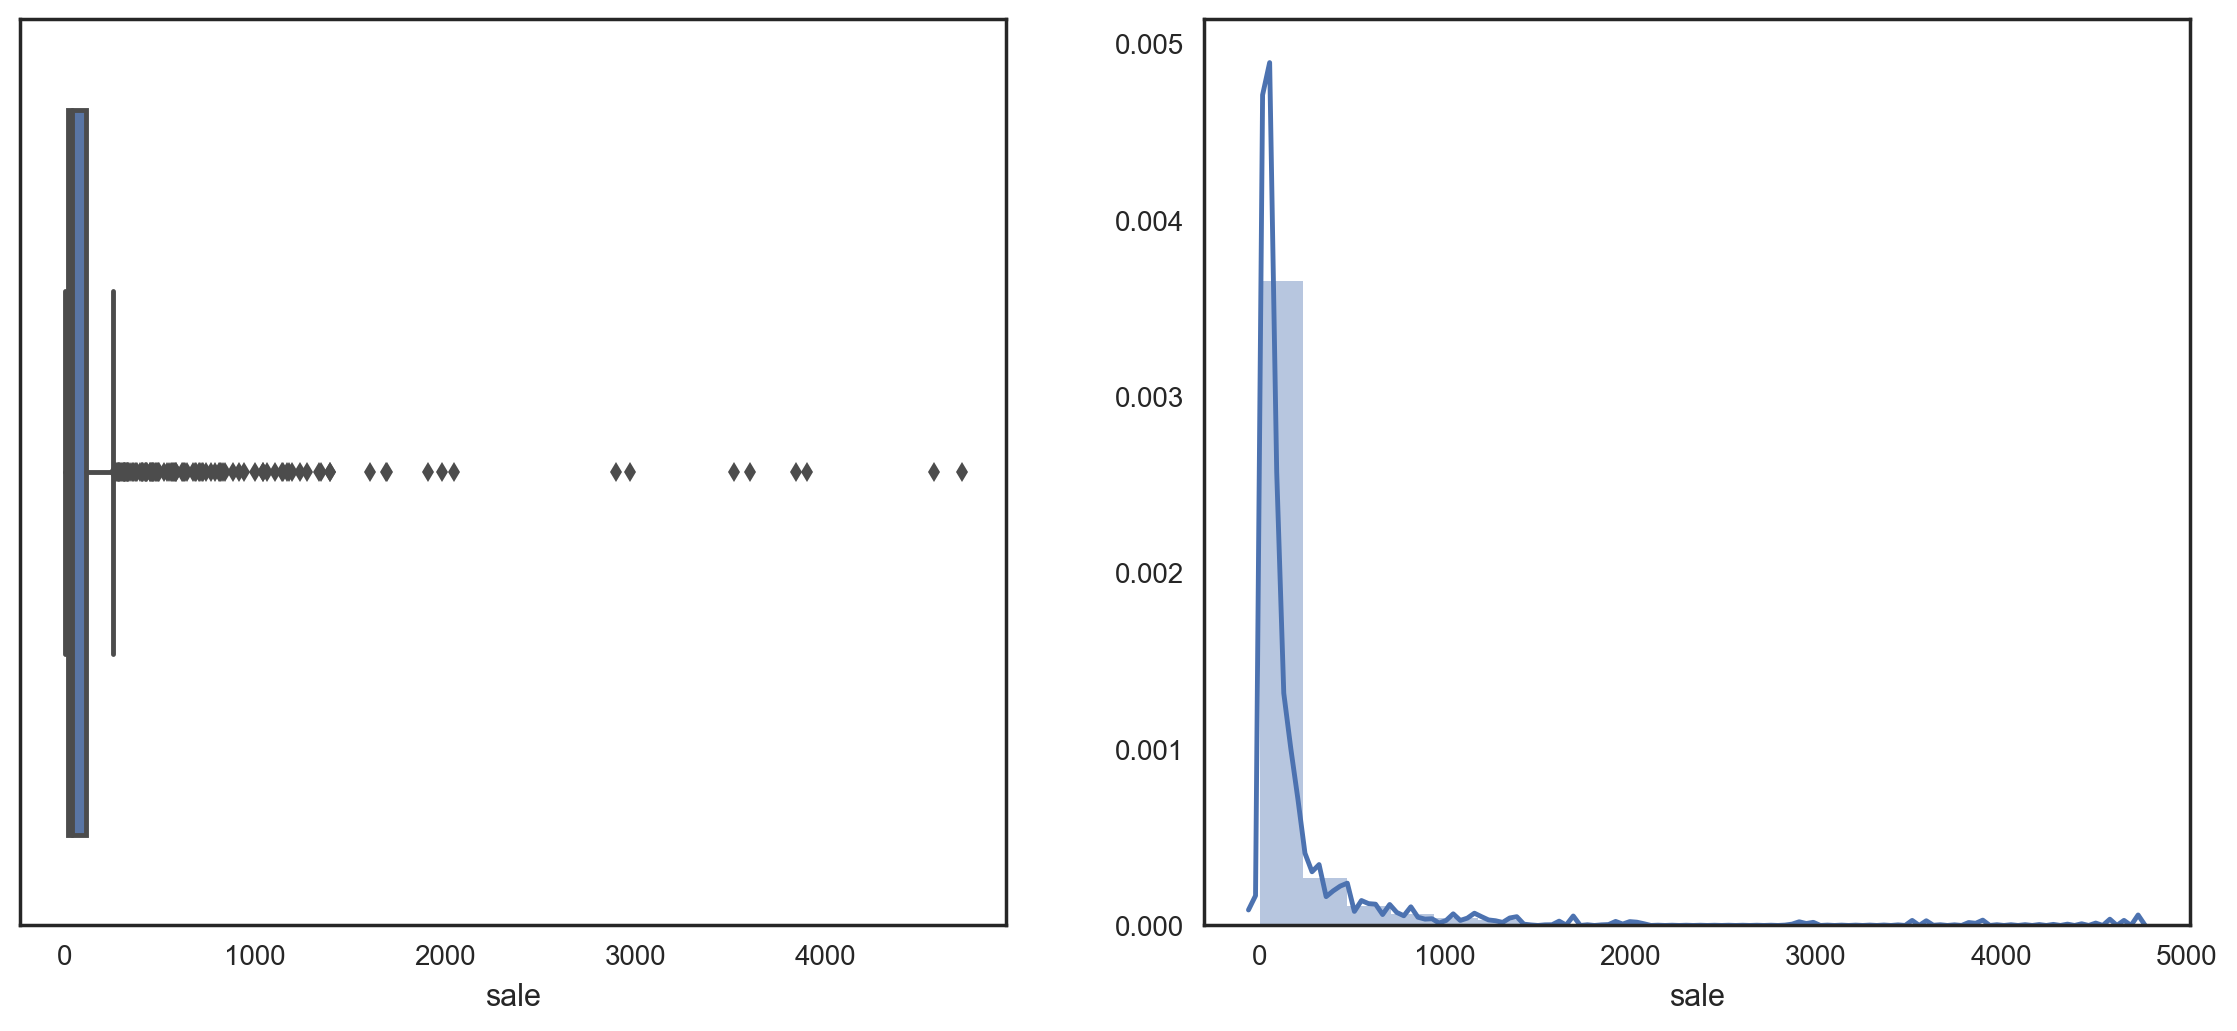

In [4]:
#file path
target_file = 'sales_granular.csv'
#load data
target_df = load_file(target_file)
#transform raw target dataframe
transform_target_df = transform_dataframe(target_df)
#calulcate average sales based on year
average_sale_df = average_sale_df (transform_target_df, 'Y')
#prepare final target variable : average daily average sale
df_target_final = final_target_df (transform_target_df)
#plot the box plot and histgram of target variable
plot_target_df(df_target_final)


# Prepare Predictors 

In [5]:
def load_file(file):
    '''loads Json file'''
    with open(file) as f:
        data = json.load(f)
    return data

def flatten_json(json_data):
    '''flatten nested json file to dataframe'''
    #flatten the nested json file    
    df_flat = json_normalize(data=json_data)
    #clean the name of flattened json file: removing prefix string 'surroundings.'
    #cleaned_names = [df_flat.columns[0]]
    #for surrounding_name in df_flat.columns.values[1:]:
        #removing prefix string 'surroundings.'
        #cleaned_name = surrounding_name.lstrip('surroundings.')
        #cleaned_names.append(cleaned_name)
    #df_flat.columns = cleaned_names
    return df_flat

In [7]:
def generate_features(df_flat):
    
    '''Create the dataframe which contains the information of the number of different surroundings in each store,
    the average total users who did the user rating (average_user_rating_total) for different surroundings 
    in each store, the average rating for different surroundings in each store, the average weekly opening hours 
    for different surroundings in each store'''
    
    def calculate_num_surroundings(df_flat,surrounding_name):
        '''calculate number of surroundings for particular surrounding category for all store(rows)'''
        num_surroundings =[]
        for i in range(df_flat.shape[0]):
            #calculate number of surroundings for particular surrounding category in each store(row)
            temp_data = len(df_flat[surrounding_name][i])
            num_surroundings.append(temp_data)
        return num_surroundings
    
    def calculate_average_user_rating_total(df_flat,surrounding_name):
        '''calculate the average_user_rating_total for particular surrounding category for all stores(rows)'''
        average_user_rating_total_list =[] 
        for i in range(df_flat.shape[0]):
            #calculate the average_user_rating_total for particular surrounding category in each store(row)
            #get the meta data from nested json
            meta_data = json_normalize(data=df_flat[surrounding_name][i])
            #If there is meta data and exists user_ratings_total, calculate the average; otherwise mark as NAN
            if not meta_data.empty and 'user_ratings_total' in meta_data : 
                average_user_rating_total = meta_data['user_ratings_total'].mean()
            else:
                average_user_rating_total = float("nan")
            average_user_rating_total_list.append(average_user_rating_total)
        return average_user_rating_total_list    
    
    def calculate_average_rating(df_flat,surrounding_name):
        '''calculate the average_rating for particular surrounding category for all stores(rows)'''
        average_rating_list =[]
        for i in range(df_flat.shape[0]):
            #calculate the average_rating for particular surrounding category in each store(row)
            #get the meta data from nested json
            meta_data = json_normalize(data=df_flat[surrounding_name][i])
            #If there is meta data and exists rating, calculate the average; otherwise mark as NAN
            if not meta_data.empty and 'rating' in meta_data : 
                average_rating = meta_data['rating'].mean()
            else:
                average_rating = float("nan")
            average_rating_list.append(average_rating)
        return average_rating_list

    def calculate_average_opening_hours(df_flat, surrounding_name):
        '''calculate the average weekly opening hours for particular surrounding category for all stores(rows)'''
        def calculate_average_opening_hours_base(opening_hours_list):
            '''calculate the average weekly opening hours for one instance'''
            total_opening_hours = []
            for day in range(len(opening_hours_list)):
                if 'close' in opening_hours_list[day] and 'open' in opening_hours_list[day]:
                    close_time = opening_hours_list[day]['close']['time']
                    open_time = opening_hours_list[day]['open']['time']
                    #transform the format of time from string to timestamp
                    time_close = datetime.strptime(close_time, '%H%M')
                    time_open = datetime.strptime(open_time, '%H%M')
                    #calculate the opening hours by subtracting open time from close time
                    diff = time_close - time_open
                    diff_hours = diff.seconds/3600
                    total_opening_hours.append(diff_hours)
                else:
                    total_opening_hours = float("nan")
            average_opening_hours = np.mean(total_opening_hours)
            return average_opening_hours 

        def calculate_individual_average_opening_hours(meta_data_list):
            '''calculate the average weekly opening hours if there are many instances '''
            total =0
            for item in meta_data_list:
                total += calculate_average_opening_hours_base(item)
            average_individual_opening_hours = total/len(meta_data_list)
            return average_individual_opening_hours 
        
        average_opening_hour_list =[]
        for i in range(df_flat.shape[0]):
            #calculate the average_rating for particular surrounding category in each store(row)
            #get the meta data from nested json
            meta_data = json_normalize(data=df_flat[surrounding_name][i])
            #If there is meta data and exists rating, calculate the average; otherwise mark as NAN
            if not meta_data.empty and 'opening_hours.periods' in meta_data : 
                average_opening_hour = calculate_individual_average_opening_hours(meta_data['opening_hours.periods'].dropna())
            else:
                average_opening_hour = float("nan")
            average_opening_hour_list.append(average_opening_hour)
        return average_opening_hour_list
    
    #Create the predictors dataframe
    predictors_df = df_flat['store_code']
    #calculate all features (number of surroundings etc) for all surrounding categories(columns)
    for surrounding_name in df_flat.columns.values[1:]:
        #calculate number of surroundings in each surrounding category(column)
        num_surroundings_data = calculate_num_surroundings(df_flat,surrounding_name)
        name_0 = surrounding_name 
        X0 = pd.DataFrame(data = num_surroundings_data, columns = [name_0])
        #calculate the average_user_rating_total in each surrounding category(column)
        average_user_rating_total_data = calculate_average_user_rating_total(df_flat,surrounding_name)
        name_1 = surrounding_name + '_' + 'average_user_rating_total'    
        X1 = pd.DataFrame(data = average_user_rating_total_data, columns = [name_1])
        #calculate the average_rating in each surrounding category(column)
        average_rating_data = calculate_average_rating(df_flat,surrounding_name)
        name_2 = surrounding_name + '_' + 'average_rating'
        X2 = pd.DataFrame(data = average_rating_data, columns = [name_2])
        #calculate the average weekly opening hours in each surrounding category(column)
        average_opening_hours_data = calculate_average_opening_hours(df_flat,surrounding_name)
        name_3 = surrounding_name + '_' + 'opening_hours'
        X3 = pd.DataFrame(data = average_opening_hours_data, columns = [name_3])
        #concatenate all of the genetated features 
        predictors_df = pd.concat([predictors_df,X0,X1,X2,X3],axis =1)  
    
    return predictors_df

In [9]:
def clean_data(raw_df, fs = True):
    '''Use FeatureSelector tool, remove some features 
    such as missing values ratio greater than 0.99 and with single unique value '''
    #clean_df = raw_df.loc[:, ~raw_df.columns.duplicated()]
    #if FeatureSelector tool is imported, remove some features
    if fs == True:
        fs = FeatureSelector(data = raw_df)
        #identify missing values ratio greater than 0.99
        fs.identify_missing(missing_threshold=0.99)
        missing_features = fs.ops['missing']
        print(missing_features)
        print('')
        #identify feature with single unique value
        fs.identify_single_unique()
        single_unique = fs.ops['single_unique']
        print(single_unique)
        print('')
        #remove features
        clean_df = fs.remove(methods = ['missing','single_unique'])   
    return clean_df

In [143]:
#file path 
data_file = 'Surroundings.json'
#load json data 
json_data = load_file(data_file)
#flatten nested json file to dataframe
df_flat = flatten_json(json_data)
#Create the predictor dataframe; the runtime may takes 2 mins
df_predictors = generate_features(df_flat)
#Clean the predictors 
df_predictors_clean = clean_data(df_predictors, fs = True)


No labels provided. Feature importance based methods are not available.
41 features with greater than 0.99 missing values.

['surroundings.airport_average_user_rating_total', 'surroundings.airport_average_rating', 'surroundings.airport_opening_hours', 'surroundings.amusement_park_average_user_rating_total', 'surroundings.amusement_park_average_rating', 'surroundings.amusement_park_opening_hours', 'surroundings.aquarium_average_user_rating_total', 'surroundings.aquarium_average_rating', 'surroundings.aquarium_opening_hours', 'surroundings.bus_station_opening_hours', 'surroundings.campground_average_user_rating_total', 'surroundings.campground_average_rating', 'surroundings.campground_opening_hours', 'surroundings.casino_average_user_rating_total', 'surroundings.casino_average_rating', 'surroundings.casino_opening_hours', 'surroundings.cemetery_average_user_rating_total', 'surroundings.cemetery_average_rating', 'surroundings.cemetery_opening_hours', 'surroundings.fire_station_opening_hou

In [150]:
df_predictors_clean.head()

,store_code,surroundings.accounting,surroundings.accounting_average_user_rating_total,surroundings.accounting_average_rating,surroundings.accounting_opening_hours,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.art_gallery_average_user_rating_total,...,surroundings.travel_agency_opening_hours,surroundings.university,surroundings.university_average_user_rating_total,surroundings.university_average_rating,surroundings.university_opening_hours,surroundings.veterinary_care,surroundings.veterinary_care_average_user_rating_total,surroundings.veterinary_care_average_rating,surroundings.veterinary_care_opening_hours,surroundings.zoo
0,10055,3,NaN,NaN,8.25,0,0,0,1,NaN,...,NaN,0,NaN,NaN,NaN,1,14.0,5.0,9.666667,0
1,10077,0,NaN,NaN,NaN,0,0,0,0,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0
2,10079,1,NaN,NaN,3.00,0,0,0,0,NaN,...,7.208333,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0
3,10086,0,NaN,NaN,NaN,0,0,0,0,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0
4,10111,0,NaN,NaN,NaN,0,0,0,0,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0


# Machine Learnig Models

In [11]:
def prepare_X_y(df_predict, target_df):
    '''join predict dataframe and target dataframe on 'store_code' and split into X and y '''
    df_all = pd.merge(df_predict, df_target_final, on ='store_code', how = 'inner')
    #fill the missing values by -1 
    df_all = df_all.fillna(-1)
    X, y = df_all.iloc[:,1:-1],df_all.iloc[:,-1]
    #log transform y value
    y = np.log(y+1)
    return X, y

def train_test_data_split (X,y):
    '''use stratified split X, y data set'''
    bins = np.linspace(0, 8, 8)
    #broken down Y by the bins 
    y_binned = np.digitize(y, bins)
    # Pass y_binned to the stratify argument
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned, random_state =123)
    return X_train, X_test, y_train, y_test


In [122]:
def cross_validate(models, X_train, y_train, k=5, num_procs=1):
    'cross validate models '
    cv_mean = {}
    cv_std = {}
    cv_score = {}
    for model in models:
        cv_score [model] = -1.0*cross_val_score(model, X_train, y_train, cv=k, n_jobs=num_procs, scoring= 'neg_mean_squared_error')
        cv_mean[model] = np.mean(cv_score [model])
        cv_std[model] = np.std(cv_score [model])       
    return cv_mean, cv_std, cv_score

def select_best_model(cv_mean):
    '''select the model with lowest mse'''
    best_model = min(cv_mean, key=cv_mean.get)
    return best_model

def best_model_fit_predict(best_model, X_train, y_train, X_test, y_test):
    '''fit and score the best model'''
    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse,preds

def print_summary(models, cv_mean, cv_std, best_model, mse_test):
    '''prints summary of models, best model '''
    print('\nModel Summaries:')
    for model in models:
        print('\n', model, '\n Average MSE during cv:', cv_mean[model])
        print(' Standard deviation during CV:', cv_std[model])
        
    print('\nBest Model:\n', best_model)
    print('\n MSE of Best Model on Validation\n', cv_mean[best_model])
    print ('\n MSE of Best Model on Test\n', mse_test)


In [12]:
# Prepare X, y
X, y = prepare_X_y (df_predictors_clean, df_target_final)
# Train test split: stratified split based on binned y values
X_train, X_test, y_train, y_test =  train_test_data_split (X,y)


In [95]:
# Hyperparameter tuned models by hand 
lr = linear_model.Lasso(alpha = 2.1)
#lr_std = make_pipeline(StandardScaler(),linear_model.Lasso())
rf = RandomForestRegressor(n_estimators=200, max_depth=5, max_features=20, min_samples_split=3, random_state =123)
xgb_reg = xgb.XGBRegressor(max_depth = 3, subsample=0.9, colsample_bytree =0.7,\
                           n_estimators=70, reg_alpha =10, random_state=0)

In [123]:
#define model container
models = [lr, rf, xgb_reg]
#do cross validation on models
cv_mean, cv_std, cv_score = cross_validate(models, X_train, y_train, k=5, num_procs=1)
#select the models with min mse
best_model =select_best_model(cv_mean)
#fit the best model and predict on the test dataset 
mse_test, preds = best_model_fit_predict(best_model, X_train, y_train, X_test, y_test)
#print model summaries
print_summary(models, cv_mean, cv_std, best_model, mse_test)



Model Summaries:

 Lasso(alpha=2.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 
 Average MSE during cv: 1.9077862470143931
 Standard deviation during CV: 0.20932337800471865

 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=123,
           verbose=0, warm_start=False) 
 Average MSE during cv: 1.741145301553449
 Standard deviation during CV: 0.2334070676073044

 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=70,
       

# Feature Importance

In [101]:
def permutation_feature_importance(model, X_test, y_test):
    '''calculate the permutation feature importance and plot '''
    plt.subplots(dpi=400)
    #use library rfpimp : function 'importance' do calculation, function 'stemplot_importances' do plot 
    I = imp.importances(model, X_test, y_test)
    imp.stemplot_importances(I, vscale=.7,width=8)
    

In [19]:
def default_feature_importance(model):
    '''save the algorithm default feature importance and plot '''
    # if model has attributes feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    feature_importances = pd.DataFrame({'Feature':X.columns, 'Importance':importances})
    feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
    #set index to 'Feature'
    feature_importances.set_index('Feature', inplace=True, drop=True)
    plt.subplots(dpi=400)
    imp.stemplot_importances(feature_importances, vscale=.7,width=8)
    

In [ ]:
#plot permutation feature importance for best model 
permutation_feature_importance(best_model, X_test, y_test)

In [ ]:
#plot default feature importance for best model 
default_feature_importance(best_model)

# Plots

No labels provided. Feature importance based methods are not available.
41 features with greater than 0.99 missing values.



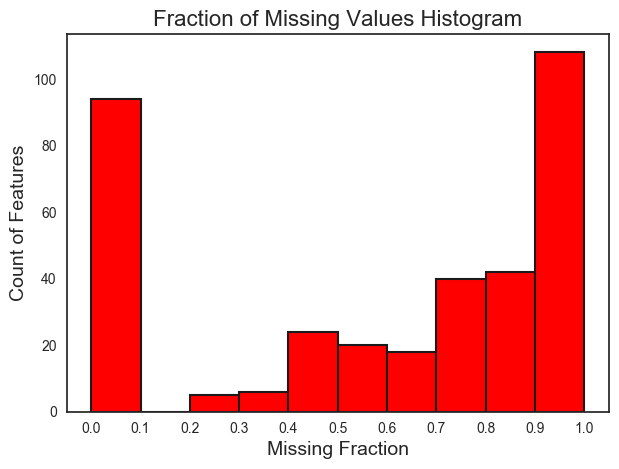

In [144]:
#plot missing values for predictors
fs_d = FeatureSelector(data = df_predictors)
fs_d.identify_missing(missing_threshold=0.99)
fs_d.plot_missing()

19 features with a single unique value.



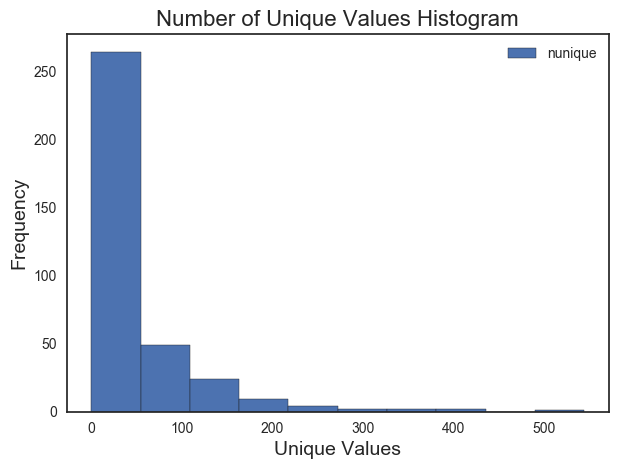

In [145]:
#plot single unique value for 
fs_d.identify_single_unique()
fs_d.plot_unique()


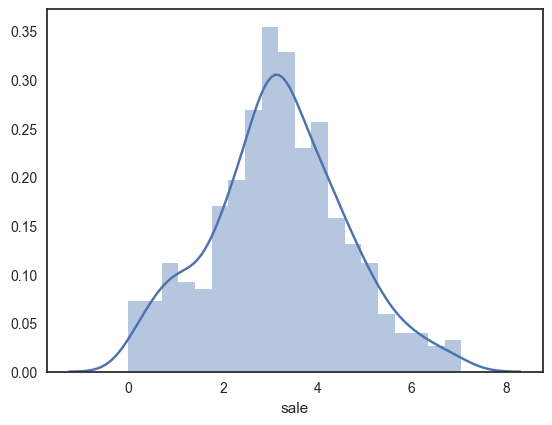

In [146]:
#distribution of y_train
sns.distplot(y_train, bins=20)


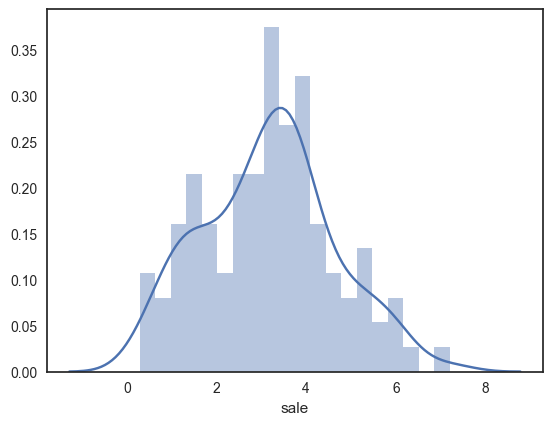

In [147]:
#distribution of y_test
sns.distplot(y_test, bins=20)


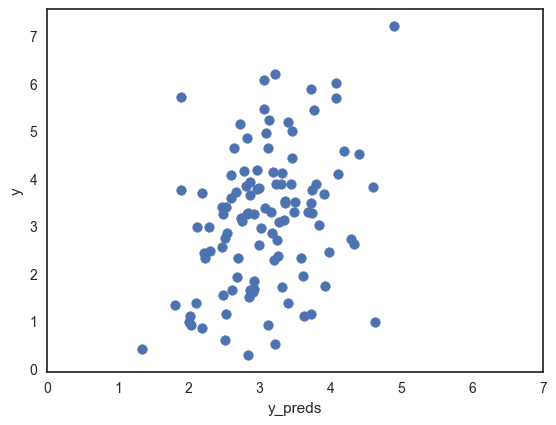

In [132]:
#y vs y_prediction
fig, ax = plt.subplots()
ax.scatter (preds,y_test)
ax.set_ylabel('y')
ax.set_xticks(np.arange(8))
ax.set_yticks(np.arange(8))
ax.set_xlabel('y_preds')

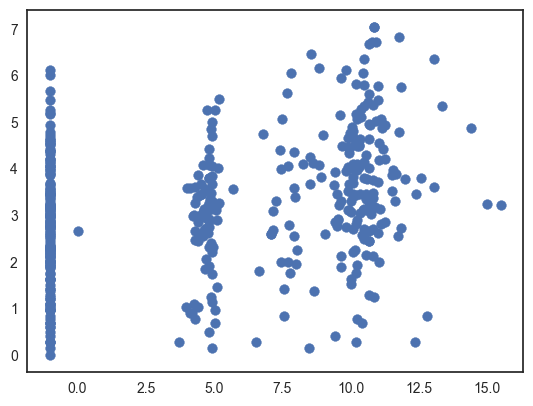

In [117]:
#scatter plot for top 1 feature
plt.scatter(X_train['surroundings.pharmacy_opening_hours'],y_train)


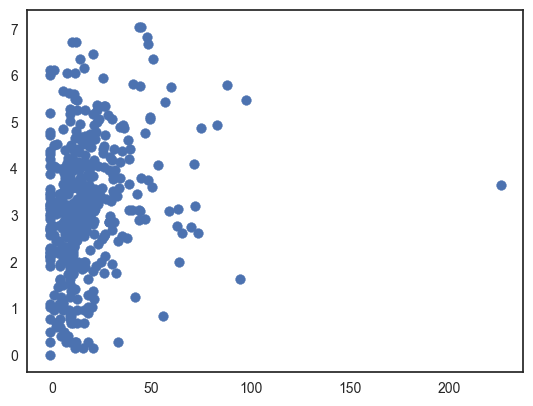

In [119]:
#scatter plot for top 2 feature
plt.scatter(X_train['surroundings.restaurant_average_user_rating_total'],y_train)


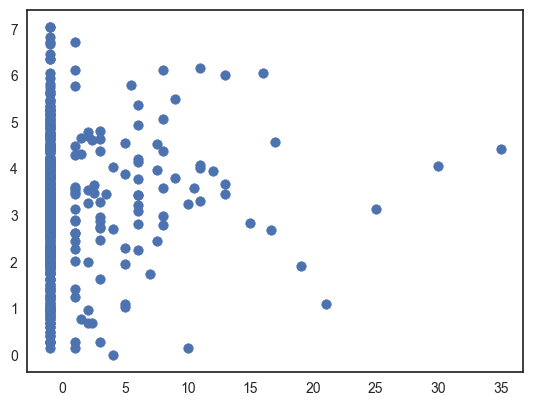

In [121]:
#scatter plot for top 3 feature
plt.scatter(X_train['surroundings.gas_station_average_user_rating_total'],y_train)
